In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
'''for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))'''

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

"for dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))"

In [2]:
from glob import glob
import os

# for plotting
import matplotlib.pyplot as plt
%matplotlib inline

# to open the images
import cv2
from PIL import Image
import scipy as sp
import gc

from skimage.filters import laplace, difference_of_gaussians
import tensorflow_addons as tfa
# to display all the columns of the dataframe in the notebook
pd.pandas.set_option('display.max_columns', None)
# data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf

# evaluate model and separate train and test


In [3]:
from sklearn.metrics import confusion_matrix, roc_auc_score
import warnings
warnings.filterwarnings("ignore")

from tensorflow.keras.layers import Layer, Input
from tensorflow.keras.initializers import RandomUniform, Initializer, Constant

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, BatchNormalization, Activation, DepthwiseConv2D, Flatten
import tensorflow.keras.backend as K

from sklearn.metrics import classification_report, roc_auc_score
from keras.optimizers import RMSprop,Adam
from keras.callbacks import LearningRateScheduler, ReduceLROnPlateau

In [4]:
catherer_path = '/kaggle/input/ranzcr-clip-catheter-line-classification'
train_path = os.path.join(catherer_path,'train')
test_path = os.path.join(catherer_path,'test')

In [5]:
# Load train.csv data
train_csv_path = os.path.join(catherer_path,'train.csv')
train_df = pd.read_csv(train_csv_path)

# classes to predict
classes = [col for col in train_df.columns if col not in ['StudyInstanceUID','PatientID']]
print(classes)

# add the .jpg to the file names in the dataset
train_df['path_name'] = train_df['StudyInstanceUID'].apply(lambda x:os.path.join(train_path,x+'.jpg'))
print("Example of a path name : {}".format(train_df['path_name'][0]))
# shape of the train data
print("\nShape of train dataframe : {}\n".format(train_df.shape))
print("check for null values :")
print(train_df.isnull().sum())

['ETT - Abnormal', 'ETT - Borderline', 'ETT - Normal', 'NGT - Abnormal', 'NGT - Borderline', 'NGT - Incompletely Imaged', 'NGT - Normal', 'CVC - Abnormal', 'CVC - Borderline', 'CVC - Normal', 'Swan Ganz Catheter Present']
Example of a path name : /kaggle/input/ranzcr-clip-catheter-line-classification/train/1.2.826.0.1.3680043.8.498.26697628953273228189375557799582420561.jpg

Shape of train dataframe : (30083, 14)

check for null values :
StudyInstanceUID              0
ETT - Abnormal                0
ETT - Borderline              0
ETT - Normal                  0
NGT - Abnormal                0
NGT - Borderline              0
NGT - Incompletely Imaged     0
NGT - Normal                  0
CVC - Abnormal                0
CVC - Borderline              0
CVC - Normal                  0
Swan Ganz Catheter Present    0
PatientID                     0
path_name                     0
dtype: int64


In [6]:
# Load test.csv data
test_csv_path = os.path.join(catherer_path,'sample_submission.csv')
test_df = pd.read_csv(test_csv_path)

# add the .jpg to the file names in the test dataset
test_df['path_name'] = test_df['StudyInstanceUID'].apply(lambda x:os.path.join(test_path,x+'.jpg'))
print("\nShape of test dataframe : {}\n".format(test_df.shape))
print("check for null values :")
print(test_df.isnull().sum())


Shape of test dataframe : (3582, 13)

check for null values :
StudyInstanceUID              0
ETT - Abnormal                0
ETT - Borderline              0
ETT - Normal                  0
NGT - Abnormal                0
NGT - Borderline              0
NGT - Incompletely Imaged     0
NGT - Normal                  0
CVC - Abnormal                0
CVC - Borderline              0
CVC - Normal                  0
Swan Ganz Catheter Present    0
path_name                     0
dtype: int64


Image size = (3056, 2544)


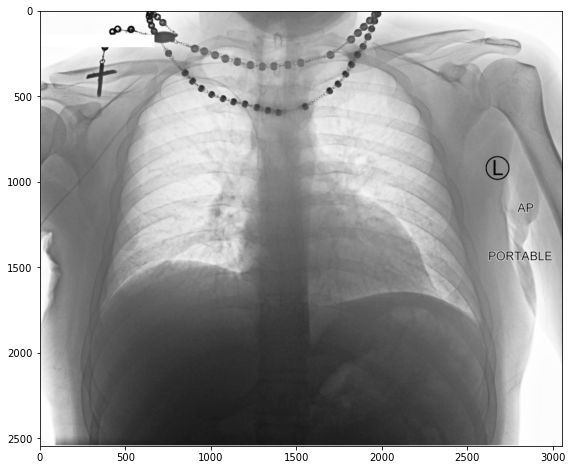

In [7]:
im_path = train_df['path_name'].iloc[200]
im_example = Image.open(im_path)
print("Image size = {}".format(im_example.size))
plt.figure(figsize=(12,8))
plt.imshow(im_example,cmap='Greys')

In [8]:
# image size
im_width= 256
im_height = 256
# batch size
batch_size = 32


In [9]:
X_train, X_valid = train_test_split(train_df,test_size=0.2,shuffle=True)
print(X_train.shape)
print(X_valid.shape)

(24066, 14)
(6017, 14)


In [10]:
Train_df = tf.data.Dataset.from_tensor_slices((X_train['path_name'].values, X_train[classes].values))

Valid_df = tf.data.Dataset.from_tensor_slices((X_valid['path_name'].values, X_valid[classes].values))

Test_df = tf.data.Dataset.from_tensor_slices((test_df['path_name'].values))

In [11]:
Train_df

<TensorSliceDataset shapes: ((), (11,)), types: (tf.string, tf.int64)>

In [12]:
def process_data_train(image_path, label):
    # returns an image (type EagerTensor) and its labels
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, size=[256,256], method=tf.image.ResizeMethod.BICUBIC,
                         preserve_aspect_ratio=False)  
    img = tf.cast(img,tf.float32)
    #img = tf.image.resize(img, [im_height,im_width])
    #img = tf.image.random_hue(image, 0.01)
    #img = tf.image.random_saturation(image, 0.70, 1.30)
    #img = tf.image.random_contrast(image, 0.80, 1.20)
    #img = tf.image.random_brightness(image, 0.10)
    
    #-----Contrast Stretching------
    
    mins = tf.reduce_min(img)
    maxs = tf.reduce_max(img)
    img = ((img-mins)*(180.0-70.0)/(maxs-mins)) + 70.0
    
    img = img/255.0
    
    #img = tf.image.per_image_standardization(img)
    
    return img, label

In [13]:
def process_data_valid(image_path, label):
    # No image modification for the vaidation data
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3) 
    img = tf.image.resize(img, size=[256,256], method=tf.image.ResizeMethod.BICUBIC,
                         preserve_aspect_ratio=False)  
    img = tf.cast(img,tf.float32)
    img = tf.reshape(img,(256,256,3))
    mins = tf.reduce_min(img)
    maxs = tf.reduce_max(img)
    img = ((img-mins)*(180.0-70.0)/(maxs-mins)) + 70.0
    img = img/255.0
    #img = tf.image.per_image_standardization(img)    

    return img, label

In [14]:
Train_df2 = Train_df.map(process_data_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
Valid_df2 = Valid_df.map(process_data_valid, num_parallel_calls=tf.data.experimental.AUTOTUNE)

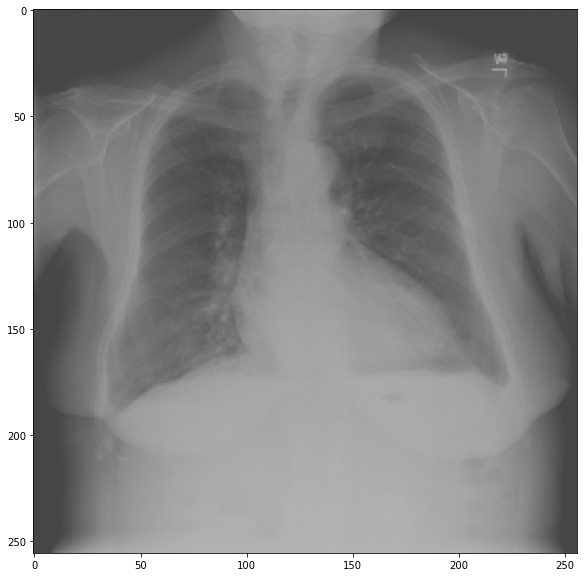

In [15]:
#plt.figure(figsize=(10,10))
for img, label in Train_df2.take(1):
    image = np.array(img)
    
plt.figure(figsize=(10,10))    
plt.imshow(image, cmap='gray')

In [16]:
def configure_for_performance(ds, batch_size = 32):
    
    ds = ds.cache('/kaggle/dump.tfcache') 
    ds = ds.repeat()
    ds = ds.shuffle(buffer_size=1024)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    
    return ds

train_ds_batch = configure_for_performance(Train_df2)
valid_ds_batch = Valid_df2.batch(32*2)
#test_ds_batch = Test_df.batch(32*2)

In [17]:
inputs = Input(shape=(256,256,3))

x1 = Conv2D(32,(3,3),activation='relu', padding='SAME', strides=2)(inputs) 

def bottleneck_block(x, expand, squeeze, kernel, resize):
    m = Conv2D(expand, (1,1), padding='SAME')(x)
    m = BatchNormalization()(m)
    m = Activation('relu')(m)
    m = DepthwiseConv2D(kernel, padding='SAME')(m)
    m = BatchNormalization()(m)
    m = Activation('relu')(m)
    if resize==True:
        m = Conv2D(squeeze, (1,1),strides=2, padding='SAME')(m)
    else:
        m = Conv2D(squeeze, (1,1), padding='SAME')(m)
    m = BatchNormalization()(m)
    return m

x1 = bottleneck_block(x1, 16,16, (3,3), resize=False)

x1 = bottleneck_block(x1, 144,24, (3,3), resize=True)
x1 = bottleneck_block(x1, 144,24, (3,3), resize=False)

x1 = bottleneck_block(x1, 240,40, (5,5), resize=True)
x1 = bottleneck_block(x1, 240,40, (5,5), resize=False)

x1 = bottleneck_block(x1, 480,80, (3,3), resize=False)
x1 = bottleneck_block(x1, 480,80, (3,3), resize=False)
x1 = bottleneck_block(x1, 480,80, (3,3), resize=False)

x1 = bottleneck_block(x1, 672,112, (5,5), resize=True)
x1 = bottleneck_block(x1, 672,112, (5,5), resize=False)
x1 = bottleneck_block(x1, 672,112, (5,5), resize=False)

x1 = bottleneck_block(x1, 1152,192, (5,5), resize=True)
x1 = bottleneck_block(x1, 1152,192, (5,5), resize=False)
x1 = bottleneck_block(x1, 1152,192, (5,5), resize=False)
x1 = bottleneck_block(x1, 1152,192, (5,5), resize=False)

x1 = bottleneck_block(x1, 1920,320, (3,3), resize=False)

x1=Flatten()(x1)
#x1 = Dense(256, activation='relu')(x1)
#x1 = Dense(128, activation='relu')(x1)
outputs = Dense(11, activation='softmax')(x1)

model_scratch = tf.keras.Model(inputs=inputs, outputs=outputs)

model_scratch.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 16)      528       
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 16)      64        
_________________________________________________________________
activation (Activation)      (None, 128, 128, 16)      0         
_________________________________________________________________
depthwise_conv2d (DepthwiseC (None, 128, 128, 16)      160       
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 16)      64    

In [18]:
#image_batch, label_batch = next(iter(train_ds_batch))

In [19]:
annealer_lrs = LearningRateScheduler(lambda x: 1e-4 * 0.9 ** x)
annealer_lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_auc', 
                                                            factor = 0.1, 
                                                            patience = 2, 
                                                            mode = 'max')

model_scratch.compile(loss=tf.keras.losses.categorical_crossentropy,
                  optimizer='Adam',
                 metrics=['AUC'])
history = model_scratch.fit(
                          train_ds_batch, 
                          validation_data = valid_ds_batch, 
                          epochs = 10, 
                          callbacks = [annealer_lrs],
                          steps_per_epoch = 256
                      )

Epoch 1/10
256/256 [==============================] - 357s 1s/step - loss: 7.2887 - auc: 0.8173 - val_loss: 3.8041 - val_auc: 0.7530
Epoch 2/10
256/256 [==============================] - 341s 1s/step - loss: 16.9363 - auc: 0.8336 - val_loss: 3.1663 - val_auc: 0.8540
Epoch 3/10
256/256 [==============================] - 318s 1s/step - loss: 24.2237 - auc: 0.8317 - val_loss: 29.1973 - val_auc: 0.7756
Epoch 4/10
256/256 [==============================] - 232s 906ms/step - loss: 32.0824 - auc: 0.8308 - val_loss: 36.5745 - val_auc: 0.8446
Epoch 5/10
256/256 [==============================] - 232s 907ms/step - loss: 37.7779 - auc: 0.8407 - val_loss: 17.1673 - val_auc: 0.8525
Epoch 6/10
256/256 [==============================] - 232s 909ms/step - loss: 54.9206 - auc: 0.8422 - val_loss: 25.3369 - val_auc: 0.8505
Epoch 7/10
256/256 [==============================] - 234s 914ms/step - loss: 61.2490 - auc: 0.8469 - val_loss: 63.8159 - val_auc: 0.8466
Epoch 8/10
256/256 [==========================